# Detecting cancer metastases on CAMELYON16 data - Prototype

## 1 Open slides, read them and understanding them to create a dataset of patches

The first stage of this project is to load, read and process slides already modified by prof. Gordon, located [here](https://drive.google.com/open?id=1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5). 

The objective is to get patches (sub images) from the original slide (.tif file) by implementing a stride that goes through the image and produces a patch according to the zoom level of the image. Once we produce those patches, filter them by the amount of gray pixels they have to detect images with no or very few tissue.

The function to implement should process one slide and output X number of patches. 

Same process should be repeated for tumor masks, assuring that the produced tumor mask patch matches the correspondent patch from the slide (basically that they are divided at the same coordinates).

Finally, we should apply that function to all slides available in the raw data folder.

The output of this stage should be patches, from the slides-tumor masks available, saved as images in this [folder](https://drive.google.com/open?id=1Ji0yKAIPW98Xs7HNutSe1ej4ULEGojxP). This is the dataset we'll use further to create a train and test sets.

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,107 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145653 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import pathlib
import math

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing import image

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path_input = './drive/My Drive/Nube/Columbia_ADL/DL-Final_Project/Raw_data/slides'
path_output = './drive/My Drive/Nube/Columbia_ADL/DL-Final_Project/Clean_images'

path_input = pathlib.Path(path_input)
path_output = pathlib.Path(path_output)
path_raw = pathlib.Path('./raw_img/')
if not os.path.exists(path_raw):
  path_raw.mkdir()

In [0]:
path_input.exists()

True

In [0]:
file_list = [x.name for x in path_input.glob('*.tif')]
# !cp drive/My\ Drive/Nube/Columbia_ADL/project_slides/DL-Final\ Project/Raw\ data/slides/tumor_091_mask.tif raw_img/
for x in file_list:
  orig = str(path_input.joinpath(x)).translate(str.maketrans({' ':'\ '}))
  dest = str(path_raw).translate(str.maketrans({' ':'\ '}))
  !cp $orig $path_raw


^C
^C


KeyboardInterrupt: ignored

In [0]:
slide_path = 'raw_img/tumor_091.tif' 
tumor_mask_path = 'raw_img/tumor_091_mask.tif'

In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from raw_img/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from raw_img/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

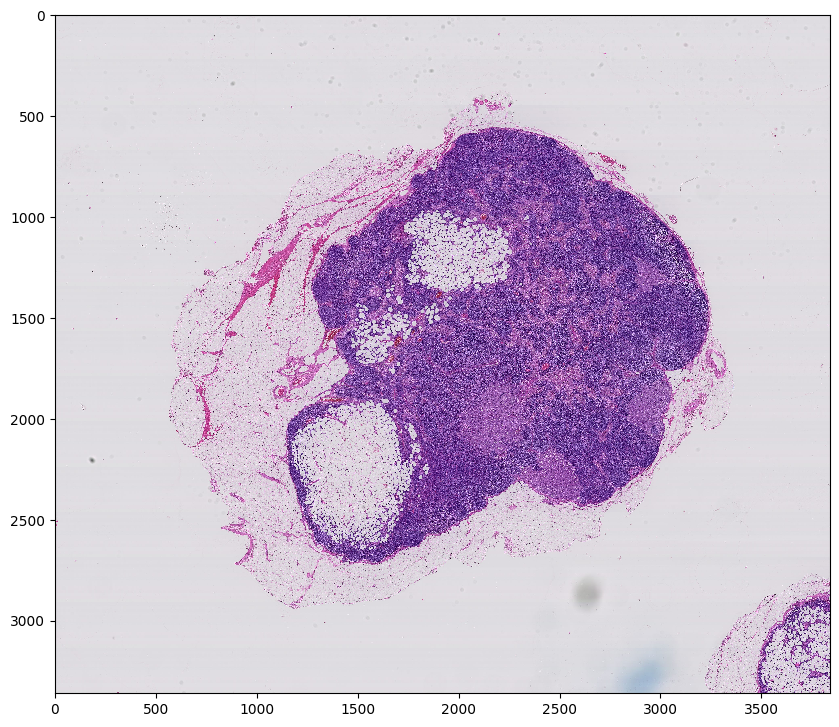

In [0]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slide.level_dimensions[4][0], 
                         height=slide.level_dimensions[4][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

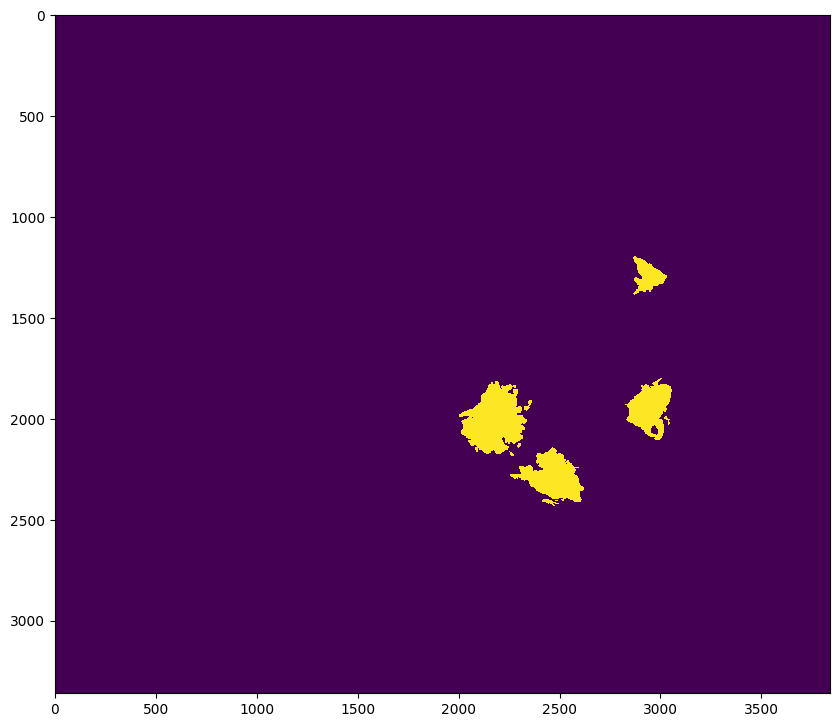

In [0]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(mask, 
                        x=0, 
                        y=0, 
                        level=4, 
                        width=slide.level_dimensions[4][0], 
                        height=slide.level_dimensions[4][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

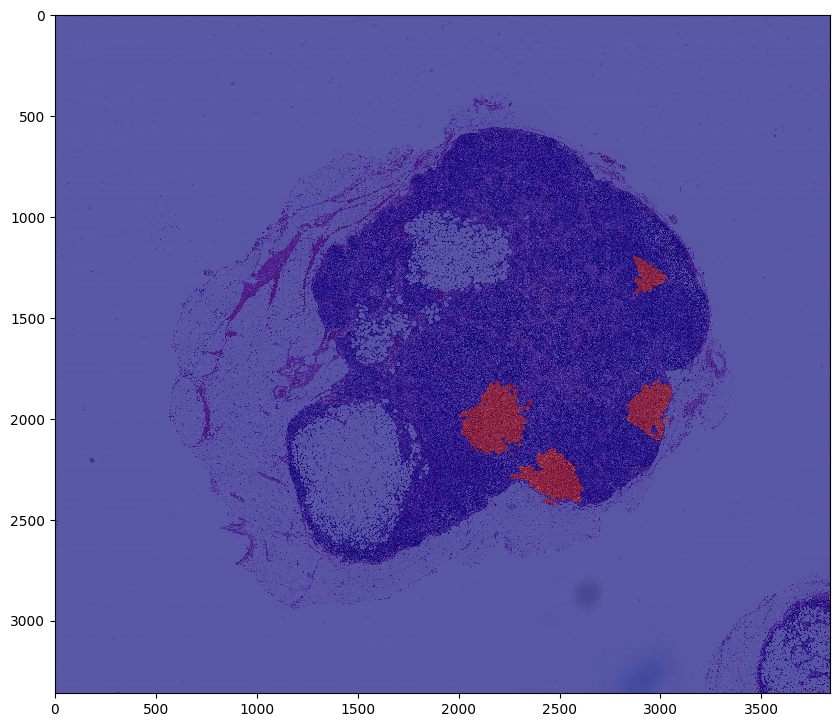

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.6) # Red regions contains cancer.

## Preprocessing
Split slides and masks in patches

In [0]:
# set level and create folders
level = 6

path_processed = './drive/My Drive/Nube/Columbia_ADL/project_slides/DL-Final Project/Clean_images' # to backup in drive
path_processed = pathlib.Path(path_processed)

path_colab_patches = pathlib.Path('/content/level'+str(level))
try:
  path_colab_patches.mkdir()
except:
  pass

folders = ['positive','negative']
for fld in folders:
  p = pathlib.Path().joinpath(path_colab_patches, fld)
  try:
    p.mkdir()
  except:
    pass

In [0]:
files_slides = [file for file in os.listdir(path_raw) if (file[-3:]=='tif' and 'mask' not in file)]
files_masks = [file for file in os.listdir(path_raw) if (file[-3:]=='tif' and 'mask' in file)]

3451212 tissue_pixels pixels out of 12902400 (26.7 percent of the image)


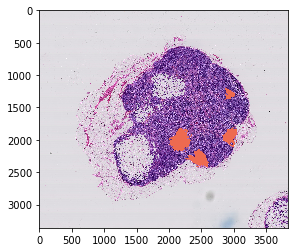

In [0]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    # plt.figure()
    # plt.imshow(im_gray, cmap='gray')
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def calc_tissue_percentage(image, intensity=0.8):
  tissue_cnt = len(list(find_tissue_pixels(image)))
  pixel_cnt = float(image.shape[0] * image.shape[1])
  return tissue_cnt, pixel_cnt, tissue_cnt / pixel_cnt

tissue_cnt, pixel_cnt, percent_tissue = calc_tissue_percentage(slide_image)
print ("%d tissue_pixels pixels out of %d (%.1f percent of the image)" % (tissue_cnt, pixel_cnt, 100*percent_tissue)) 

def apply_mask(im, mask, color=(238,106,80)):
    masked = np.copy(im)
    mask = np.array(list(mask))
    masked[mask[:,0],mask[:,1]] = color
    # for x,y in mask: masked[x][y] = color
    return masked

tissue_pixels = find_tissue_pixels(1-mask_image)
tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)
# tissue_regions[:3], [(x,y) for x,y in find_tissue_pixels(1-mask_image)][:3]

In [0]:
def split_slide(path_in, file, path_out, level, patch_size=None, window_size=128, stride=None, show=False, intensity=0.8):
  if patch_size is None:
    patch_size = int(math.ceil(window_size * math.sqrt(2)))

  if stride is None:
    stride = window_size

  assert window_size <= patch_size, 'patch_size must be greater or equal to window_size'

  slide_path = path_in.joinpath(file)
  slide = open_slide(str(slide_path))
  factor = slide.level_downsamples[level]

  mask_file = file[:-4] + '_mask.tif'
  mask_path = path_in.joinpath(mask_file)
  try:
    mask = open_slide(str(mask_path))
    print(str(mask_path))
  except:
    raise NameError(str(mask_path) + ' doesn\'t exist')

  x_coord = 0
  while x_coord + patch_size <= slide.level_dimensions[level][0]:
    y_coord = 0
    while y_coord + patch_size <= slide.level_dimensions[level][1]:
      # split tumor slide
      img = read_slide(slide, 
                      x=x_coord*int(factor),
                      y=y_coord*int(factor),
                      level=level,
                      width=patch_size,
                      height=patch_size)
      msk = read_slide(mask, 
                      x=x_coord*int(factor),
                      y=y_coord*int(factor),
                      level=level,
                      width=patch_size,
                      height=patch_size)[:,:,0]
      # choose to save or print
      if show:
        # msk = find_tissue_pixels(1-msk)
        # img = apply_mask(img,msk)
        plt.figure()
        plt.title(str(x_coord)+','+str(y_coord))
        plt.imshow(img)
        plt.imshow(msk, cmap='jet', alpha=0.6)
        # plt.imshow(msk, alpha=0.8, cmap='inferno')
      else:
        _, _, tissue_percentage = calc_tissue_percentage(img, intensity)
        if tissue_percentage >= 0.1: # DO NOT confuse intensity with the % of tissue in the slide
          output_file = file[:-4] + '_level' + str(level) + '_x' + str(x_coord) + '_y' + str(y_coord)
          output_mask_file = mask_file[:-4] + '_level' + str(level) + '_x' + str(x_coord) + '_y' + str(y_coord)

          # label as tissue WITH cancer
          if np.max(msk) > 0.: 
            np.save(path_out.joinpath('positive', output_file), img)
            np.save(path_out.joinpath('positive', output_mask_file), msk)
            img = image.array_to_img(img, data_format='channels_last')
            image.save_img(path_out.joinpath('positive', output_file +'.jpg'), img, file_format='jpeg')
          # label as tissue WITHOUT cancer
          else:
            np.save(path_out.joinpath('negative', output_file), img)
            np.save(path_out.joinpath('negative', output_mask_file), msk)
            img = image.array_to_img(img, data_format='channels_last',)
            image.save_img(path_out.joinpath('negative', output_file +'.jpg'), img, file_format='jpeg')
      
      y_coord += stride + 1
    
    x_coord += stride + 1

### Split 1 slide and mask

In [0]:
file = 'tumor_091.tif'
patch_size = None #Default: sqrt(2)*window_size
window_size = 128
stride = 50 # equal to window_size to avoid overlapping

split_slide(path_raw, file, path_colab_patches, level, patch_size, window_size, stride, show=False)

raw_img/tumor_091_mask.tif


In [0]:
tmp_path = path_colab_patches.joinpath('positive')
lst = [x for x in tmp_path.glob('**/*.npy')]
print(lst)
lst.sort()
for x in lst:
  img = np.load(x)
  plt.figure()
  plt.title(x)
  plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

## 2.1 Data Augmentation*


The main issue here is to ensure a set that has balanced classes, i.e.,  fair good proportion of patches with normal tissue vs. tumor tissue.

**Question:** *To combat the rarity of tumor patches, we apply several data augmentations* (paper)


> Is it correct to do data augmentation before train/test splitting?

> Is data augmentation performed to increase only tumor patches or all patches?

Data augmentation techniques:


*   90x degrees rotation
*   Left-right flips
*   Brightness
*   Saturation
*   Hue
*   Contrast


*Note that this step it's not necessary for a first prototype working from end-to-end. It should be consider later to improve results.

**Question:** If we leave data augmentation for later, how come we balance classes?


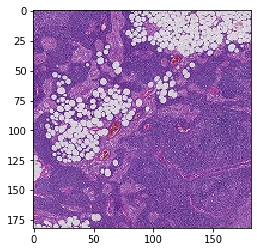

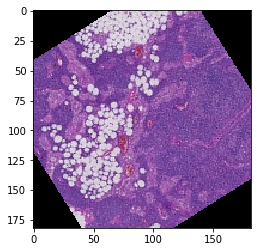

In [0]:
img = np.load('level6/positive/tumor_091_level6_x357_y306.npy')
# img = image.array_to_img(img)
plt.figure()
plt.imshow(img)
img = image.random_rotation(img, 90,0,1,2,fill_mode='constant')
plt.figure()
plt.imshow(img)

## 2.2 Create Train/Test sets

Depending on the data augmentation strategy and with patches created in Step 1, we need to split the slides patches and its correspondent tumor-mask patch into a training and a test set.

*   Could test set contain augmented data?
*   How to sample patches to have balanced train/test sets? It's a simple split enough? / subsample vs oversample vs weights



### Data Generator

In [0]:
train_datagen = image.ImageDataGenerator(horizontal_flip=True, 
                                         vertical_flip=True)
train_gen = train_datagen.flow_from_directory(path_colab_patches, 
                                              target_size=(224,224), 
                                              batch_size=39,
                                              class_mode='binary')

Found 156 images belonging to 2 classes.


## 3 Transfer Learning

Although using a pretrained model with ImageNet images could hurt accuracy, this is a good place to start.

Train patches obtained from Step 2.2 on MobileNetV2 model with weights pre-trained on ImageNet. First attempt should be for small amount of data: patches from one image using one zoom level (7 or maybe 6).

**Simple model: MobileNetV2(imagenet) + Flatten layer + 2 Dense layer**


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPool2D, Flatten
mn2 = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                        include_top=False,
                                        weights='imagenet')
for layer in mn2.layers:
  layer.trainable = False

model = tf.keras.models.Sequential()
model.add(mn2)
model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1003536   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 3,261,554
Trainable params: 1,003,570
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [0]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=4, epochs=100)

Epoch 1/100
4/4 [==============================] - 2s 466ms/step - loss: 2.4478 - acc: 0.6538
Epoch 2/100
4/4 [==============================] - 2s 437ms/step - loss: 0.6871 - acc: 0.6731
Epoch 3/100
4/4 [==============================] - 2s 439ms/step - loss: 0.6840 - acc: 0.6987
Epoch 4/100
4/4 [==============================] - 2s 437ms/step - loss: 0.6931 - acc: 0.6667
Epoch 5/100
4/4 [==============================] - 2s 436ms/step - loss: 0.6931 - acc: 0.6795
Epoch 6/100
4/4 [==============================] - 2s 437ms/step - loss: 0.6843 - acc: 0.6859
Epoch 7/100
4/4 [==============================] - 2s 444ms/step - loss: 0.6799 - acc: 0.6731
Epoch 8/100
4/4 [==============================] - 2s 440ms/step - loss: 0.6886 - acc: 0.6795
Epoch 9/100
4/4 [==============================] - 2s 441ms/step - loss: 0.6800 - acc: 0.6603
Epoch 10/100
4/4 [==============================] - 2s 439ms/step - loss: 0.6931 - acc: 0.6923
Epoch 11/100
4/4 [==============================] - 2s 439m

In [0]:
for layer in mn2.layers:
  layer.trainable = False

for layer in mn2.layers[-3:]:
  layer.trainable = True

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1003536   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 3,261,554
Trainable params: 1,415,730
Non-trainable params: 1,845,824
_________________________________________________________________


In [0]:
history2 = model.fit_generator(train_gen,
                              steps_per_epoch=4, epochs=50)

Epoch 1/50
4/4 [==============================] - 2s 454ms/step - loss: 0.5050 - acc: 0.9423
Epoch 2/50
4/4 [==============================] - 2s 410ms/step - loss: 0.4911 - acc: 0.9103
Epoch 3/50
4/4 [==============================] - 2s 412ms/step - loss: 0.4760 - acc: 0.9295
Epoch 4/50
4/4 [==============================] - 2s 412ms/step - loss: 0.4934 - acc: 0.9359
Epoch 5/50
4/4 [==============================] - 2s 411ms/step - loss: 0.5037 - acc: 0.9167
Epoch 6/50
4/4 [==============================] - 2s 415ms/step - loss: 0.4657 - acc: 0.9487
Epoch 7/50
4/4 [==============================] - 2s 413ms/step - loss: 0.7559 - acc: 0.9295
Epoch 8/50
4/4 [==============================] - 2s 414ms/step - loss: 0.6444 - acc: 0.9231
Epoch 9/50
4/4 [==============================] - 2s 413ms/step - loss: 0.5020 - acc: 0.9423
Epoch 10/50
4/4 [==============================] - 2s 415ms/step - loss: 0.5159 - acc: 0.9295
Epoch 11/50
4/4 [==============================] - 2s 413ms/step - lo

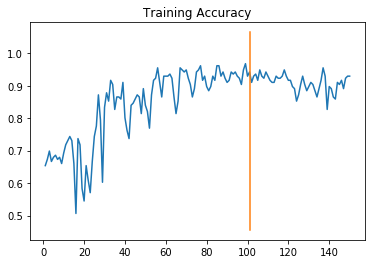

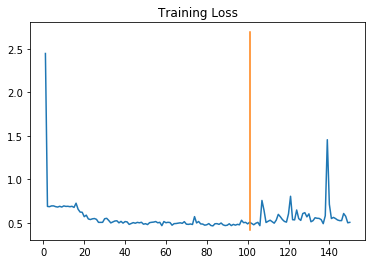

In [0]:
acc = np.array(history.history['acc'] +history2.history['acc'])
loss = np.array(history.history['loss'] +history2.history['loss'])
plt.plot(range(1,151), acc)
plt.plot([101,101],[0.9*np.min(acc),1.1*np.max(acc)])
plt.title('Training Accuracy')
plt.show()

plt.plot(range(1,151), loss)
plt.plot([101,101],[0.9*np.min(loss),1.1*np.max(loss)])
plt.title('Training Loss')
plt.show()

## 4 Model Predictions: HeatMap

**Question:** how to combine output from an ensamble model that trains on different zooms, i.e., how to combine different predictions for different number of patches? 

## 5 Evaluation Metric

Which ones: sensitivity/precision, specificity/recall, accuracy, loss, f1, _____, own ?